In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gc
import time
import dask.array as da
import numpy as np
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots

from distributed import Client
from dask.array.routines import matmul_org, matmul
from dask.distributed import wait, progress
from dask.diagnostics import ResourceProfiler

In [3]:
from plotly import io as pio
pio.renderers.default = "png+plotly_mimetype"

In [4]:
# holds dask client
c = None

In [5]:
def get_dask_cluster(n_workers=1):
    # By default we use a single separate process to get fresh memory
    # stats on each client. GIL shouln't be a problem in this pipeline,
    # also org matmul runs out of memory when there is more processes to
    # split the memory (for larger inputs)
    if c:
        c.shutdown()
        # when we shutdown the cluster, there is an exception message after 30s
        # to keep it clean, let's sleep a bit
        time.sleep(60)
    return Client(n_workers=n_workers)

In [6]:
def get_data(n: int, m: int, chunks=(1000, 250)):
    X = da.random.random(size=(n, m), chunks=chunks)
    Y = da.random.random(size=(n, 3), chunks=(chunks[0], -1))
    return X, Y

def perf_test(matmul_fn, X, Y):
    """Perf test is transposition, followed by multiplication and max"""
    with ResourceProfiler() as prof:
        R = matmul_fn(X.T, Y)
        result = R.max().compute()
    return result, prof

def perf_suite(matmul_fn):
    """Here we test the impact of the size of the contraction axis"""
    results = []
    for n in 10**np.array([3, 3.5, 4, 4.5, 5, 5.5, 6]):
        m = 1000
        X, Y = get_data(int(n), m)
        _, prof = perf_test(matmul_fn, X, Y)
        results.append((m, n, prof.results))

    return pd.DataFrame([
        dict(m=r[0], n=r[1], mem=e.mem)
        for r in results
        for e in r[2]
    ])

In [7]:
def graph_mem_and_cpu(perf_org, perf_new, text):
    f = make_subplots(rows=2, cols=1,
                      specs=[[{"secondary_y": True}], [{"secondary_y": True}]],
                      subplot_titles=("Original matmul", "New matmul"))
    
    f_mem = px.scatter(perf_org.results, x="time", y="mem", opacity=.5,)
    f_mem.data[0]["name"] = "memory"
    f_mem.data[0]["showlegend"] = True
    f.add_trace(f_mem.data[0])
    f_cpu = px.scatter(perf_org.results, x="time", y="cpu", color_discrete_sequence=["red"], opacity=.5)
    f_cpu.data[0]["name"] = "cpu"
    f_cpu.data[0]["showlegend"] = True
    f.add_trace(f_cpu.data[0], secondary_y=True)
    
    
    f_mem = px.scatter(perf_new.results, x="time", y="mem", opacity=.5,)
    f.add_trace(f_mem.data[0], row=2, col=1)
    f_cpu = px.scatter(perf_new.results, x="time", y="cpu", color_discrete_sequence=["red"], opacity=.5)
    f.add_trace(f_cpu.data[0], secondary_y=True, row=2, col=1)
    
    
    f.update_yaxes(title_text="CPU [%]", secondary_y=True)
    f.update_yaxes(title_text="memory [MB]", secondary_y=False)
    f.update_xaxes(title_text="time [seconds]", row=2)
    f.update_layout(title=f"Memory/CPU graph ({text})", height=768)
    f.show()

## New matmul results

In [8]:
c = get_dask_cluster()
c

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 8,Total memory: 15.95 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50820,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 15.95 GiB
Comm: tcp://127.0.0.1:50837,Total threads: 8
Dashboard: http://127.0.0.1:50838/status,Memory: 15.95 GiB
Nanny: tcp://127.0.0.1:50823,


In [9]:
gc.collect()

153

In [10]:
%%time
new_df = perf_suite(matmul)

Wall time: 43.2 s


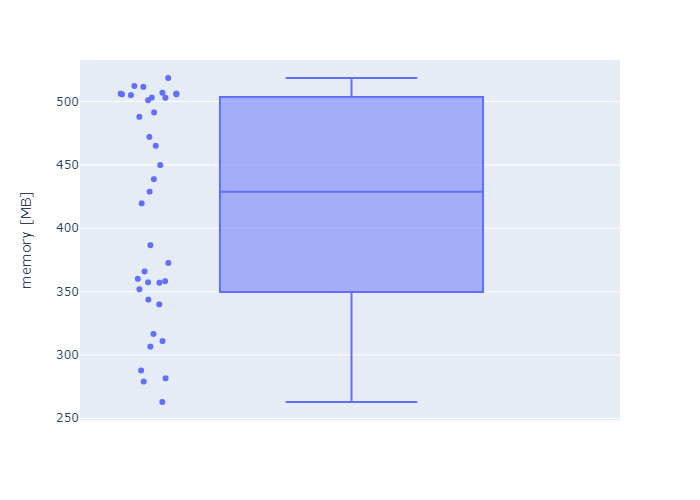

In [11]:
px.box(new_df, y="mem", points="all", labels={"mem": "memory [MB]"})

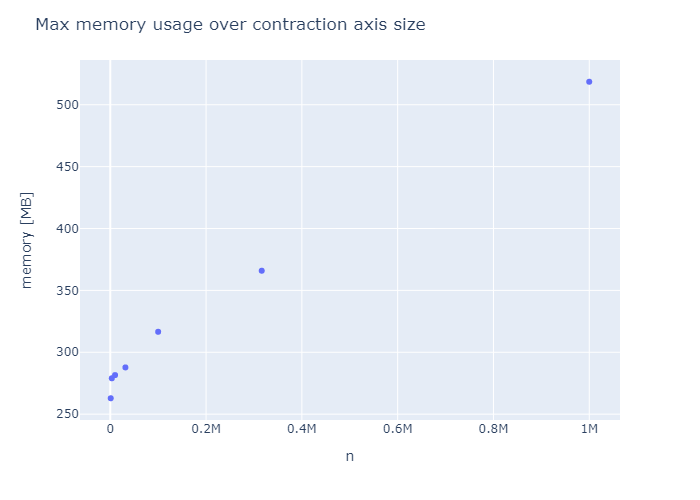

In [12]:
f = px.scatter(new_df.groupby(["n", "m"]).max().reset_index(drop=False),
               x="n", y="mem", labels={"mem": "memory [MB]"})
f.update_layout(title="Max memory usage over contraction axis size")

The memory footprint goes up stably similar to the original matmul (as seen below).

## Original matmul results

In [13]:
# Restart the dask cluster to start from clean state
c = get_dask_cluster()
c

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 8,Total memory: 15.95 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:51069,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 15.95 GiB
Comm: tcp://127.0.0.1:51079,Total threads: 8
Dashboard: http://127.0.0.1:51080/status,Memory: 15.95 GiB
Nanny: tcp://127.0.0.1:51072,


In [14]:
gc.collect()

2858

In [15]:
%%time
master_df = perf_suite(matmul_org)

Wall time: 45.2 s


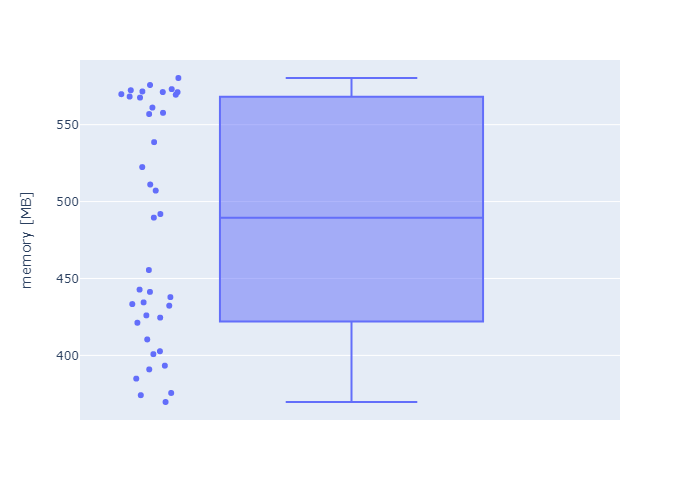

In [16]:
px.box(master_df, y="mem", points="all", labels={"mem": "memory [MB]"})

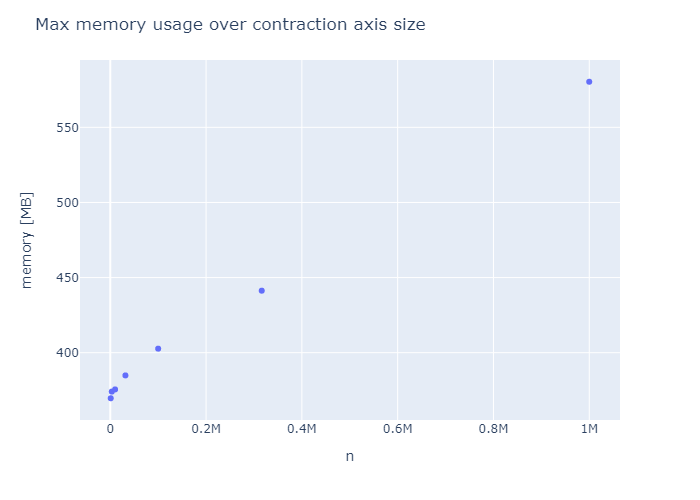

In [17]:
f = px.scatter(master_df.groupby(["n", "m"]).max().reset_index(drop=False),
               x="n", y="mem", labels={"mem": "memory [MB]"})
f.update_layout(title="Max memory usage over contraction axis size")

Memory usage is more or else stable despite increased input size. 

## Large input, data doesn't fit in memory

My laptop has 16GB of memory. This operation multiplies two matrices of shapes: `(1e3, 1e7)` @ `(1e7, 3)`. Data type is `float64`. This data doesn't fully fit into memory of my laptop, which is the intended test (if you run this on a different machine, you might need to adjust the size).

In [18]:
c = get_dask_cluster()
c

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 8,Total memory: 15.95 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:51289,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 15.95 GiB
Comm: tcp://127.0.0.1:51304,Total threads: 8
Dashboard: http://127.0.0.1:51305/status,Memory: 15.95 GiB
Nanny: tcp://127.0.0.1:51292,


In [19]:
X_7, Y_7 = get_data(n=10**7, m=1000)

In [20]:
# this matrix is transposed before matmul
X_7

dask.array<random_sample, shape=(10000000, 1000), dtype=float64, chunksize=(1000, 250), chunktype=numpy.ndarray>

In [21]:
Y_7

dask.array<random_sample, shape=(10000000, 3), dtype=float64, chunksize=(1000, 3), chunktype=numpy.ndarray>

In [22]:
gc.collect()

62

In [23]:
%%time
resl7, perfl7 = perf_test(matmul, X_7, Y_7)

Wall time: 4min 9s


In [24]:
gc.collect()

5800

In [25]:
%%time
resl7_org, perfl7_org = perf_test(matmul_org, X_7, Y_7)

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Wall time: 4min 28s


In [26]:
assert np.allclose(resl7, resl7_org, rtol=0)

Same results, similar execution time (~4min 13s vs ~4min 28s). No surprise here &mdash; the original matmul implementation and the new implementation similar.

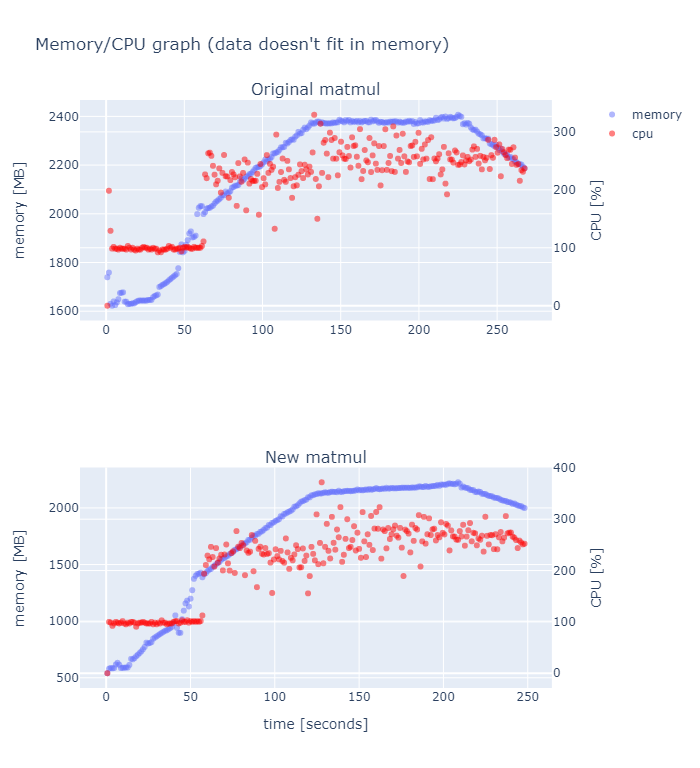

In [27]:
graph_mem_and_cpu(perfl7_org, perfl7, text="data doesn't fit in memory")

Above we can see the memory footprints of both implementations are similar.

## Data fits in memory

In [28]:
# the full size of these is less than 10GB
X_6, Y_6 = get_data(n=10**6, m=1000)

In [29]:
gc.collect()

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


11845

In [30]:
%%timeit
perf_test(matmul, X_6, Y_6)

24.8 s ± 699 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
gc.collect()

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


73

In [32]:
%%time
resl6, perfl6 = perf_test(matmul, X_6, Y_6)

Wall time: 25.1 s


In [33]:
gc.collect()

1983

In [34]:
%%timeit
perf_test(matmul_org, X_6, Y_6)

26.4 s ± 910 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
gc.collect()

104

In [36]:
%%time
resl6_org, perfl6_org = perf_test(matmul_org, X_6, Y_6)

Wall time: 28.2 s


In [37]:
assert np.allclose(resl6, resl6_org, rtol=0)

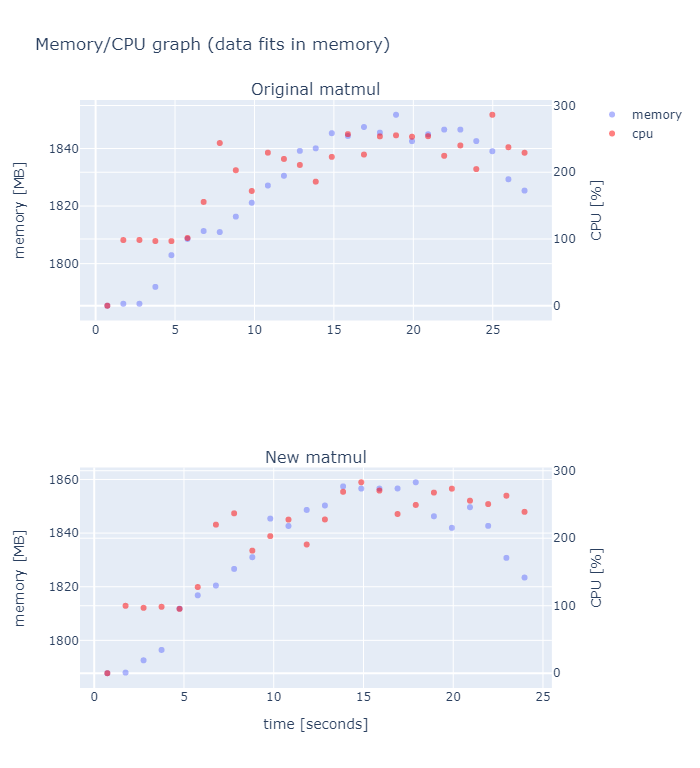

In [38]:
graph_mem_and_cpu(perfl6_org, perfl6, "data fits in memory")

Both implementations have similar speeds. We could improve the time of both implementations by adjusting the chunk size to allow more memory for matmul.

In [39]:
X_6_lc, Y_6_lc = get_data(n=10**6, m=1000, chunks=(10000, 1000))

In [40]:
gc.collect()

4141

In [41]:
%%timeit
perf_test(matmul, X_6_lc, Y_6_lc)

4.91 s ± 453 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [42]:
gc.collect()

0

In [43]:
%%time
resl6_lc, perfl6_lc = perf_test(matmul, X_6_lc, Y_6_lc)

Wall time: 5.4 s


In [44]:
gc.collect()

727

In [45]:
%%timeit
perf_test(matmul_org, X_6_lc, Y_6_lc)

4.99 s ± 472 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [46]:
gc.collect()

0

In [47]:
%%time
resl6_lc_org, perfl6_lc_org = perf_test(matmul_org, X_6_lc, Y_6_lc)

Wall time: 4.75 s


In [48]:
assert np.allclose(resl6_lc, resl6_lc_org, rtol=0)

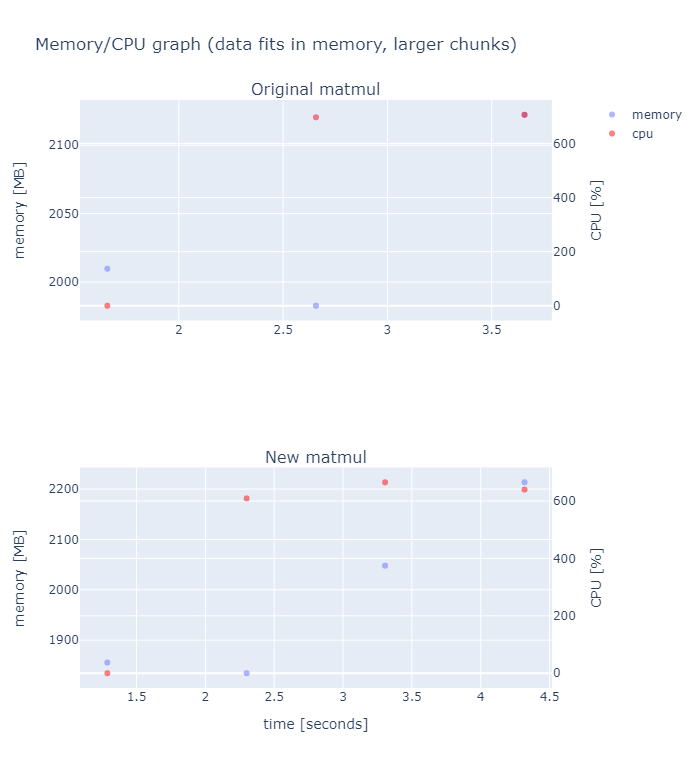

In [49]:
graph_mem_and_cpu(perfl6_lc_org, perfl6_lc, "data fits in memory, larger chunks")

With both matmul's we have good control over the memory and execution time tradeoff. Larger chunks lead to shorter execution times (to some limit obviously), at the cost of memory. Computation is still chunked (no concatenation overhead). In this case by increasing the chunk size, the new matmul is slightly faster.

Next we can measure what happens if we remove chunking from the contraction axis. This likely will show the concatenation overhead.

In [50]:
c = get_dask_cluster()
c

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 8,Total memory: 15.95 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52004,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 15.95 GiB
Comm: tcp://127.0.0.1:52041,Total threads: 8
Dashboard: http://127.0.0.1:52042/status,Memory: 15.95 GiB
Nanny: tcp://127.0.0.1:52007,


In [51]:
X_6_nc, Y_6_nc = get_data(n=10**6, m=1000, chunks=(10**6, 1000))

In [52]:
gc.collect()

4301

In [53]:
%%timeit
perf_test(matmul, X_6_nc, Y_6_nc)

15.3 s ± 441 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [54]:
gc.collect()

1387

In [55]:
%%time
resl6_nc, perfl6_nc = perf_test(matmul, X_6_nc, Y_6_nc)

Wall time: 15 s


In [56]:
gc.collect()

364

In [57]:
%%timeit
perf_test(matmul_org, X_6_nc, Y_6_nc)

15.4 s ± 488 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [58]:
gc.collect()

425

In [59]:
%%time
resl6_nc_org, perfl6_nc_org = perf_test(matmul_org, X_6_nc, Y_6_nc)

Wall time: 14.9 s


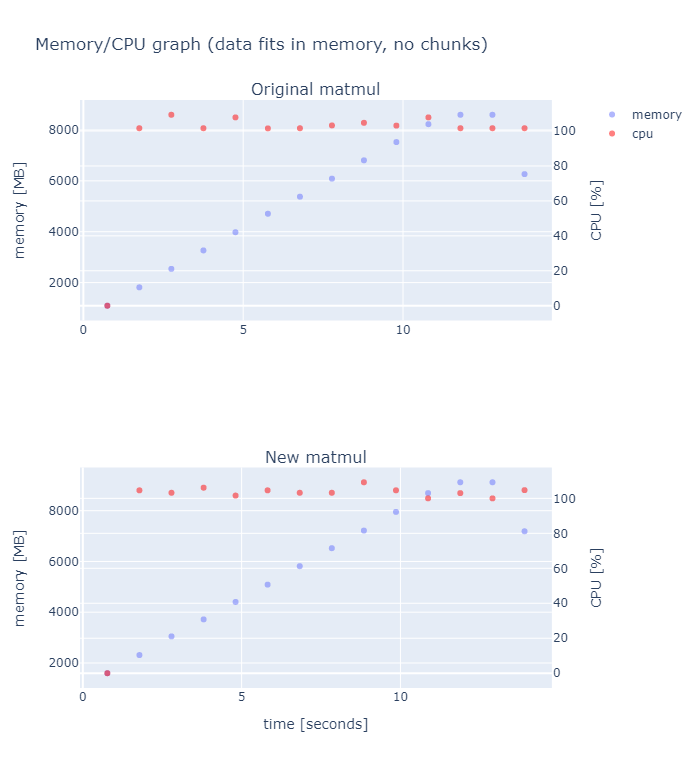

In [60]:
graph_mem_and_cpu(perfl6_nc_org, perfl6_nc, "data fits in memory, no chunks")

## Multiprocess cluster (comm overhead)

In [61]:
# my laptop has 8 cores, let's get 8 processes each with 1 processing thread
c = get_dask_cluster(8)
c

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 8,Total memory: 15.95 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52409,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 15.95 GiB
Comm: tcp://127.0.0.1:52505,Total threads: 1
Dashboard: http://127.0.0.1:52506/status,Memory: 1.99 GiB
Nanny: tcp://127.0.0.1:52418,


In [62]:
gc.collect()

3570

In [63]:
%%timeit
perf_test(matmul, X_6, Y_6)

21.3 s ± 1.1 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [64]:
gc.collect()

133

In [65]:
%%time
resl6_proc, perfl6_proc = perf_test(matmul, X_6, Y_6)

Wall time: 24.3 s


In [66]:
gc.collect()

1689

In [67]:
%%timeit
perf_test(matmul_org, X_6, Y_6)

20.1 s ± 1.82 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [68]:
gc.collect()

177

In [69]:
%%time
resl6_proc_org, perfl6_proc_org = perf_test(matmul_org, X_6, Y_6)

Wall time: 19.7 s


Let's try to reduce the number of workers to 4 (thus increasing the memory/thread ratio).

In [70]:
c = get_dask_cluster(4)
c

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 15.95 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52933,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 15.95 GiB
Comm: tcp://127.0.0.1:52988,Total threads: 2
Dashboard: http://127.0.0.1:52989/status,Memory: 3.99 GiB
Nanny: tcp://127.0.0.1:52936,


In [71]:
gc.collect()

2333

In [72]:
%%timeit
perf_test(matmul_org, X_6, Y_6)

17.1 s ± 592 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [73]:
gc.collect()

180

In [74]:
%%time
resl6_proc4_org, perfl6_proc4_org = perf_test(matmul_org, X_6, Y_6)

Wall time: 18 s


In [75]:
gc.collect()

1124

In [76]:
%%timeit
perf_test(matmul, X_6, Y_6)

16.9 s ± 830 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [77]:
gc.collect()

67

In [78]:
%%time
resl6_proc4, perfl6_proc4 = perf_test(matmul, X_6, Y_6)

Wall time: 19 s


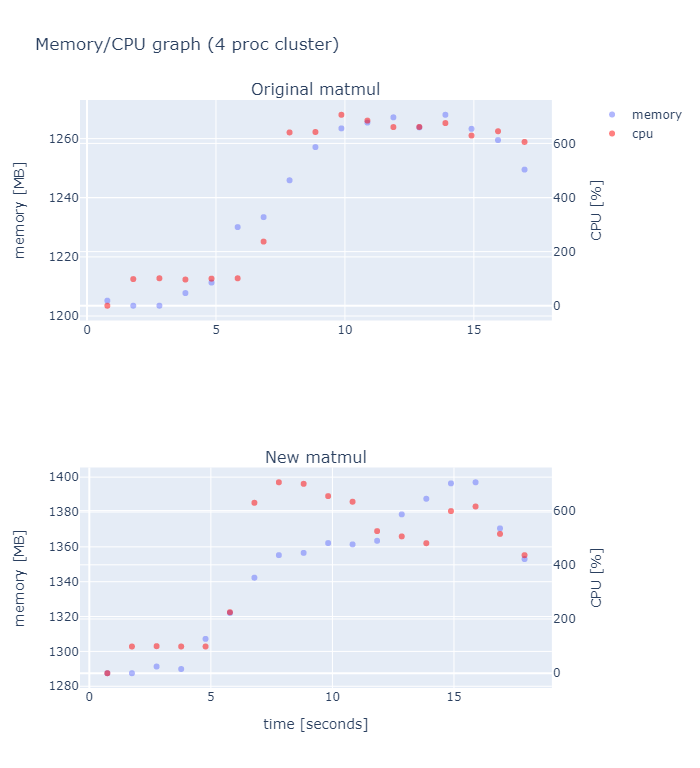

In [79]:
graph_mem_and_cpu(perfl6_proc4_org, perfl6_proc4, "4 proc cluster")

## Chunking in all dims

In [80]:
c = get_dask_cluster()
c

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 8,Total memory: 15.95 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:53346,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 15.95 GiB
Comm: tcp://127.0.0.1:53361,Total threads: 8
Dashboard: http://127.0.0.1:53362/status,Memory: 15.95 GiB
Nanny: tcp://127.0.0.1:53349,


In [81]:
X = da.random.random(size=(1e3, 1e6), chunks=(250, 1000))
Y = da.random.random(size=(1e6, 1e3), chunks=(1000, 250))

In [82]:
gc.collect()

5221

In [83]:
%%timeit
(X @ Y).compute()

2min 26s ± 8.44 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [84]:
gc.collect()

418

In [85]:
%%time
(X @ Y).compute()

Wall time: 2min 18s


array([[250104.63988682, 250045.54661481, 249954.65082525, ...,
        249702.30743252, 250023.56445638, 249887.77721021],
       [250072.59834647, 249813.90834024, 250139.55212358, ...,
        249639.46227925, 249961.6672563 , 249647.36731003],
       [250410.22997653, 250200.13927145, 250168.69878237, ...,
        250013.30008079, 250096.45926583, 249931.28112001],
       ...,
       [250096.73222262, 250124.38726786, 250096.44100569, ...,
        249644.66436672, 249947.16105029, 249701.23906436],
       [250178.41759551, 250206.29279122, 250333.36874149, ...,
        249779.4675749 , 250193.10647311, 249917.34296462],
       [250013.11893907, 249965.41350541, 249998.99619617, ...,
        249851.78562233, 250003.04231071, 249872.90348467]])

In [86]:
gc.collect()

917

In [87]:
%%timeit
matmul_org(X, Y).compute()

3min 5s ± 11.7 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [88]:
gc.collect()

338

In [89]:
%%time
matmul_org(X, Y).compute()

Wall time: 3min 11s


array([[250104.63988682, 250045.54661481, 249954.65082525, ...,
        249702.30743252, 250023.56445638, 249887.77721021],
       [250072.59834647, 249813.90834024, 250139.55212358, ...,
        249639.46227925, 249961.6672563 , 249647.36731003],
       [250410.22997653, 250200.13927145, 250168.69878237, ...,
        250013.30008079, 250096.45926583, 249931.28112001],
       ...,
       [250096.73222262, 250124.38726786, 250096.44100569, ...,
        249644.66436672, 249947.16105029, 249701.23906436],
       [250178.41759551, 250206.29279122, 250333.36874149, ...,
        249779.4675749 , 250193.10647311, 249917.34296462],
       [250013.11893907, 249965.41350541, 249998.99619617, ...,
        249851.78562233, 250003.04231071, 249872.90348467]])

## nd input

In [90]:
X = da.random.random(size=(3, 3, 1e3, 1e5), chunks=(1, 3, 1000, 10000))
Y = da.random.random(size=(3, 3, 1e5, 1e3), chunks=(1, 3, 10000, 1000))

In [91]:
X

dask.array<random_sample, shape=(3, 3, 1000, 100000), dtype=float64, chunksize=(1, 3, 1000, 10000), chunktype=numpy.ndarray>

In [92]:
gc.collect()

741

In [93]:
%%time
nd_res = (X @ Y).compute()

Wall time: 56.7 s


In [94]:
gc.collect()

1652

In [95]:
%%time
nd_res_org = matmul_org(X, Y).compute()

Wall time: 55.6 s


Here we can see that both matmuls will perform 30 matmul ops (10 chunks on contraction axis * 3 chunks on 1st dimension) on chunks and reduce that via tree reduction to get the final result.

In [96]:
assert np.allclose(nd_res, nd_res_org, rtol=0)

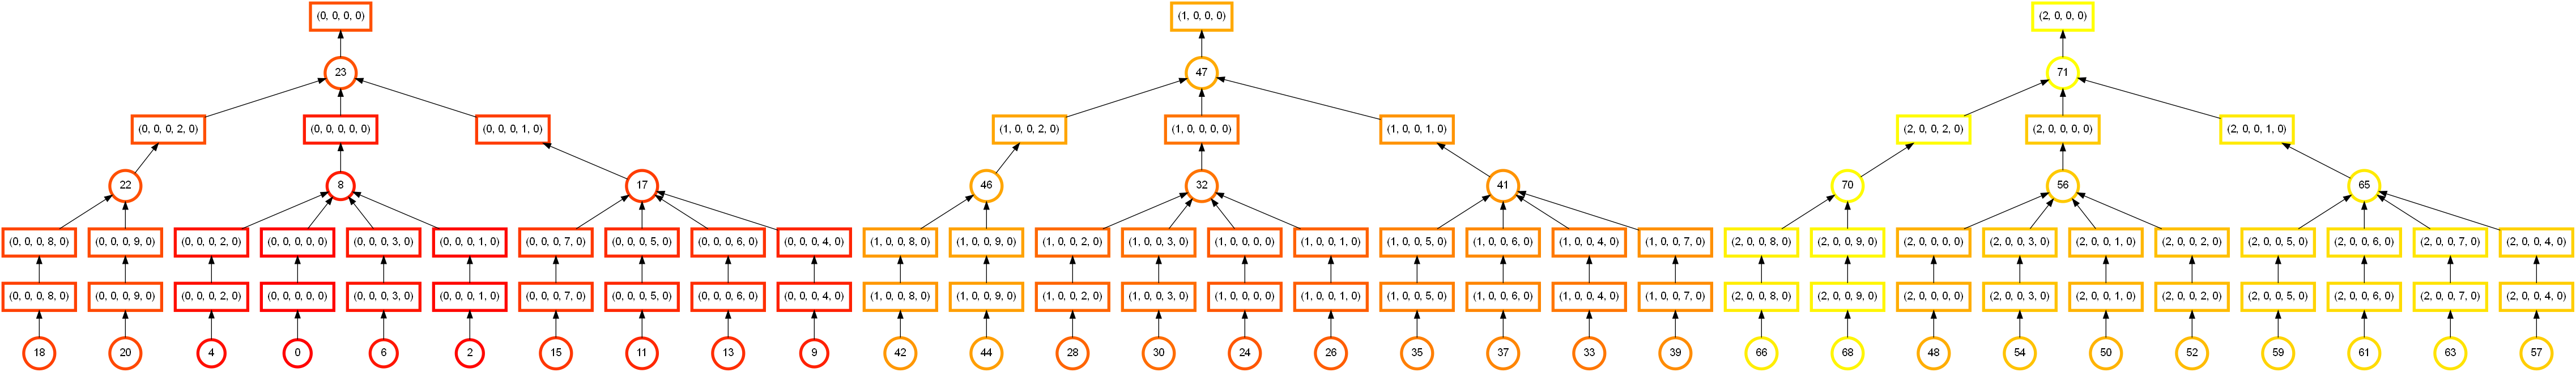

In [97]:
(X @ Y).visualize(filename="", optimize_graph=True, color="order", cmap="autumn", node_attr={"penwidth": "4"})

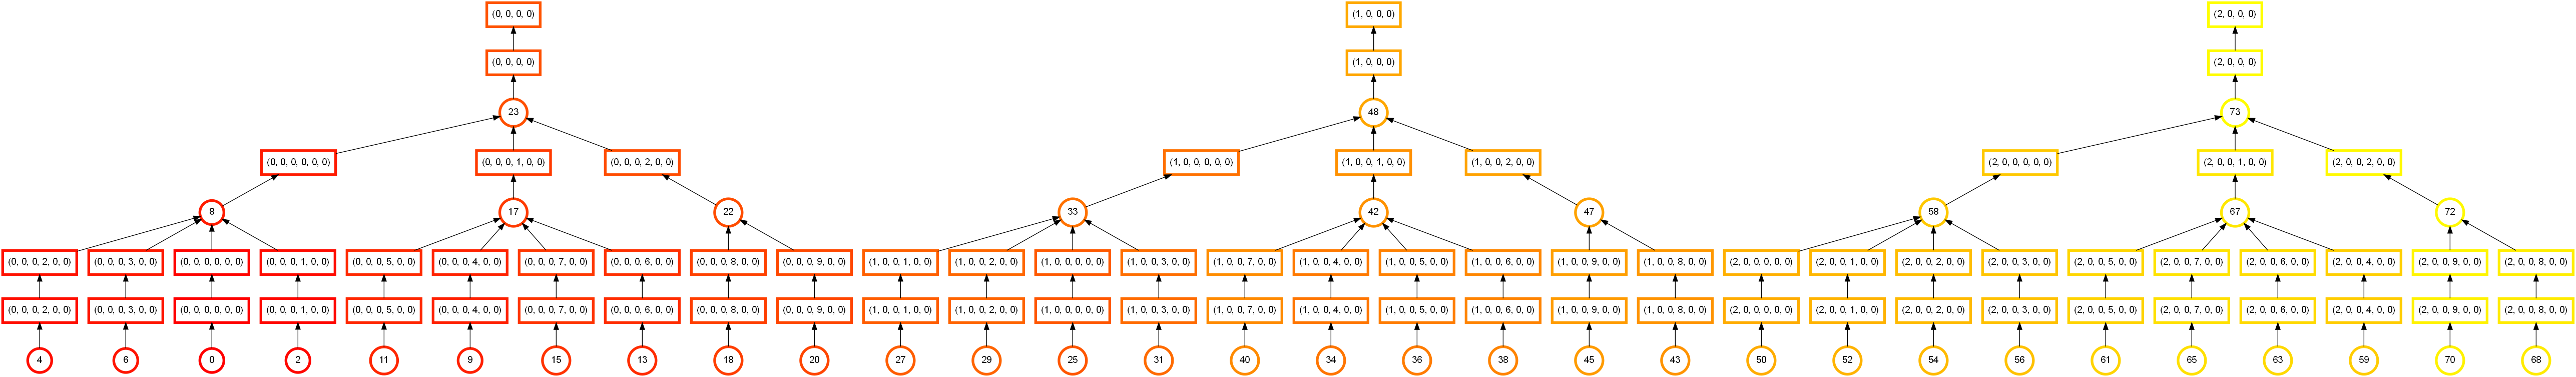

In [98]:
matmul_org(X, Y).visualize(filename="", optimize_graph=True, color="order", cmap="autumn", node_attr={"penwidth": "4"})

In [99]:
c.shutdown()
time.sleep(60)

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


Here we can see that at the final stages of the computation, the original matmul takes one step more than the new matmul to get to the result.  Everything else is essentially the same, structure-wise.  We also notice from the node labels that the new matmul has less dimensions to deal with than the original one. 